## Train Network Basics

## How to use the dataset class

Loading a dataset requires the data to be in the correct format (see Prepare data tutorial). Just create the dataset object and use the load method:

In [1]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
)


from meegnet.dataloaders import EpochedDataset

data_path = "/home/arthur/nvme/eventclf"

# use Dataset class for data that has already been cut into trials
# else, use RestDataset with additional parameters of window and overlap to create trials.
dataset = EpochedDataset(
    sfreq=500, # sampling frequency of 500 Hz
    n_subjects=100, # only load 100 subjects for demonstration purposes
    n_samples=100, # limit the number of samples for each subject to 100
    sensortype="Grad", # only use gradiometers
    lso=True, # use leave subject out for data splits
)

dataset.load(data_path)

03/19/2025 05:59:16 PM Logging subjects and targets from /home/arthur/nvme/eventclf...


## How to use the network class

Create the model object instance of the Model class and then use the train method with the dataset previously created.

In [2]:
from meegnet.network import Model

save_path = data_path
net_option = "meegnet"
input_size = dataset.data[0].shape
n_outputs = 2 # Here we have 2 possible outputs, binary classification task.
name = "eventclf_meegnet"

net_params = {"linear": 100, "hlayers": 3, "dropout": .5}
my_model = Model(name, net_option, input_size, n_outputs, save_path, net_params=net_params)

print(my_model.net)

my_model.train(dataset, max_epoch=15, verbose=1)

/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
03/19/2025 05:59:34 PM Creating DataLoaders...


MEEGNet(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 100, kernel_size=(102, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 200, kernel_size=(1, 9), stride=(1, 1))
    (3): MaxPool2d(kernel_size=(1, 20), stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Conv2d(200, 200, kernel_size=(1, 9), stride=(1, 1))
    (6): MaxPool2d(kernel_size=(1, 20), stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(200, 100, kernel_size=(1, 9), stride=(1, 1))
    (9): MaxPool2d(kernel_size=(1, 20), stride=1, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Flatten()
    (12): Dropout(p=0.5, inplace=False)
  )
  (classif): Sequential(
    (0): Linear(in_features=31900, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=2, bias=True)
  )
)


03/19/2025 05:59:35 PM Starting Training with:
03/19/2025 05:59:35 PM Batch size: 128
03/19/2025 05:59:35 PM Learning rate: 1e-05
03/19/2025 05:59:35 PM Patience: 10
03/19/2025 05:59:35 PM Maximum Epoch: 15


We can print the train and validation loss of the network during training, as well as the training and validation accuracy during training.

This is helpful to check that the network learns correctly and that early stop is well implemented: stopping before overfitting.

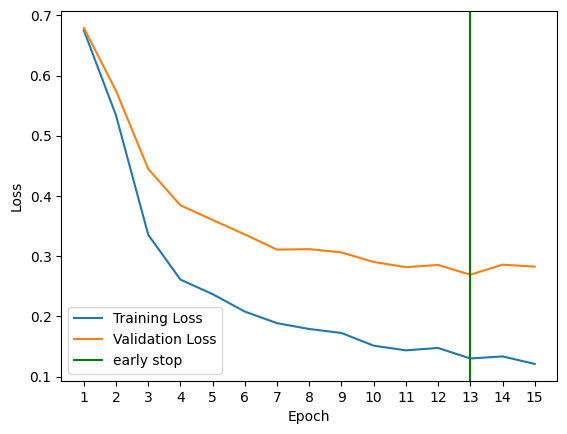

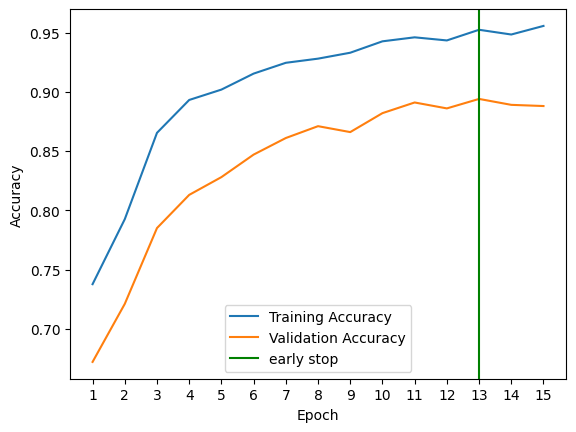

In [3]:
my_model.plot_loss()
my_model.plot_accuracy();

In our example, you can see from the figures, gap between the last epoch (15) and the best epoch (13) is closer than the patience (10 by default). It means the max_epoch parameter we imposed is too small, and the network training stopped before it could reach an optimum.

In order to correct that, we can increase the max_epoch parameter and continue training, or not set it at all but that could take a few hours.

In [4]:
my_model.train(dataset, continue_training=True, verbose=1)

03/19/2025 06:00:59 PM Creating DataLoaders...
03/19/2025 06:00:59 PM Starting Training with:
03/19/2025 06:00:59 PM Batch size: 128
03/19/2025 06:00:59 PM Learning rate: 1e-05
03/19/2025 06:00:59 PM Patience: 10


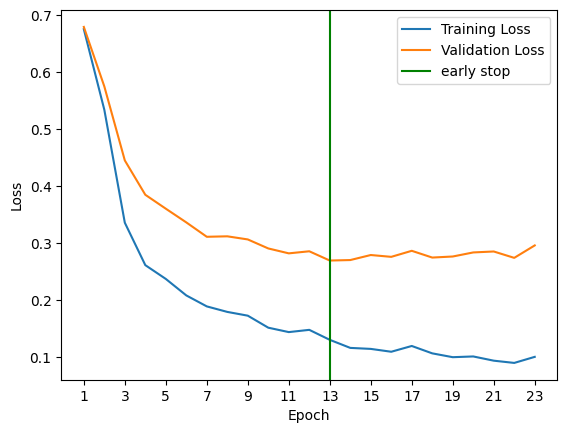

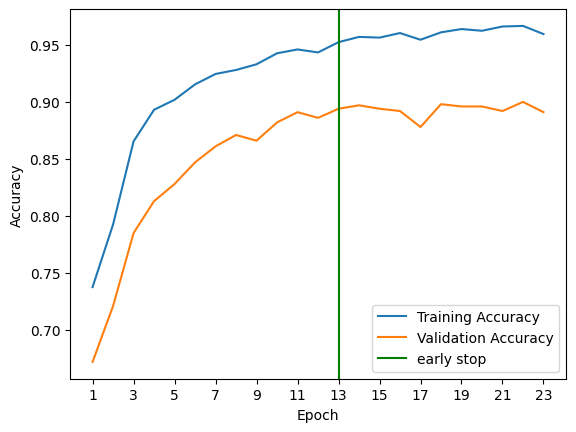

In [5]:
my_model.plot_loss()
my_model.plot_accuracy();

Now we have a better picture of the training process, and we can see that we stopped early, 10 epochs after the best epoch (13).

All training progress can be accessed through the tracker object inside the Model:

In [6]:
print("Content of tracker.progress dictionary:")
for key, value in my_model.tracker.progress.items():
    print(f"{key}, {type(value)}")

print("\nContent of tracker.best dictionary:")
for key, value in my_model.tracker.best.items():
    print(f"{key}, {value}")

Content of tracker.progress dictionary:
train_loss, <class 'list'>
train_accuracy, <class 'list'>
validation_loss, <class 'list'>
validation_accuracy, <class 'list'>

Content of tracker.best dictionary:
train_loss, 0.13024012744426727
train_accuracy, 0.9523749947547913
validation_loss, 0.26935023069381714
validation_accuracy, 0.8939999938011169
epoch, 12


Note that here best epoch is 10 because of how python indexes. The best epoch is the 13th one, which is indexed at 12.